# 生成z-order

## 基础函数

In [26]:
import torch


def generate_grid_coordinates(H: int, W: int) -> torch.Tensor:
    y_coords = torch.arange(H, dtype=torch.float32)
    x_coords = torch.arange(W, dtype=torch.float32)
    yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')
    grid = torch.stack((xx, yy), dim=-1)
    return grid

def morton_encode_2d_tensor_x(coords: torch.Tensor) -> torch.Tensor:
    x = coords[..., 0]
    y = coords[..., 1]
    x = x.long()
    y = y.long()
    x = (x | (x << 16)) & 0x0000FFFF0000FFFF
    x = (x | (x << 8)) & 0x00FF00FF00FF00FF
    x = (x | (x << 4)) & 0x0F0F0F0F0F0F0F0F
    x = (x | (x << 2)) & 0x3333333333333333
    x = (x | (x << 1)) & 0x5555555555555555
    y = (y | (y << 16)) & 0x0000FFFF0000FFFF
    y = (y | (y << 8)) & 0x00FF00FF00FF00FF
    y = (y | (y << 4)) & 0x0F0F0F0F0F0F0F0F
    y = (y | (y << 2)) & 0x3333333333333333
    y = (y | (y << 1)) & 0x5555555555555555
    return x | (y << 1)

def morton_encode_2d_tensor_y(coords: torch.Tensor) -> torch.Tensor:
    x = coords[..., 0]
    y = coords[..., 1]
    x = x.long()
    y = y.long()
    x = (x | (x << 16)) & 0x0000FFFF0000FFFF
    x = (x | (x << 8)) & 0x00FF00FF00FF00FF
    x = (x | (x << 4)) & 0x0F0F0F0F0F0F0F0F
    x = (x | (x << 2)) & 0x3333333333333333
    x = (x | (x << 1)) & 0x5555555555555555
    y = (y | (y << 16)) & 0x0000FFFF0000FFFF
    y = (y | (y << 8)) & 0x00FF00FF00FF00FF
    y = (y | (y << 4)) & 0x0F0F0F0F0F0F0F0F
    y = (y | (y << 2)) & 0x3333333333333333
    y = (y | (y << 1)) & 0x5555555555555555
    return y | (x << 1)

def calculate_avg_morton_difference(morton_encoded_tensor: torch.Tensor) -> torch.Tensor:
    H, W = morton_encoded_tensor.shape
    avg_diff_tensor = torch.zeros_like(morton_encoded_tensor, dtype=torch.float32)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    for r in range(H):
        for c in range(W):
            current_morton_val = morton_encoded_tensor[r, c].item()
            sum_of_differences = 0.0
            num_valid_neighbors = 0
            actual_neighbor_coords = []
            for dr, dc in neighbor_offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < H and 0 <= nc < W:
                    actual_neighbor_coords.append((nr, nc))
            if not actual_neighbor_coords:
                avg_diff_tensor[r, c] = 0.0
                continue
            for nr, nc in actual_neighbor_coords:
                neighbor_morton_val = morton_encoded_tensor[nr, nc].item()
                sum_of_differences += (neighbor_morton_val - current_morton_val)
                num_valid_neighbors += 1
            if num_valid_neighbors > 0:
                avg_diff_tensor[r, c] = sum_of_differences / num_valid_neighbors
    return avg_diff_tensor

def calculate_max_morton_difference(morton_encoded_tensor: torch.Tensor) -> torch.Tensor:
    H, W = morton_encoded_tensor.shape
    max_diff_tensor = torch.zeros_like(morton_encoded_tensor, dtype=torch.float32)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    for r in range(H):
        for c in range(W):
            current_morton_val = morton_encoded_tensor[r, c].item()
            actual_neighbor_coords = []
            for dr, dc in neighbor_offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < H and 0 <= nc < W:
                    actual_neighbor_coords.append((nr, nc))
            if not actual_neighbor_coords:
                max_diff_tensor[r, c] = 0.0
                continue
            max_of_differences = 0.0
            for nr, nc in actual_neighbor_coords:
                neighbor_morton_val = morton_encoded_tensor[nr, nc].item()
                max_of_differences = max(abs(neighbor_morton_val - current_morton_val), max_of_differences)
                max_diff_tensor[r, c] = max_of_differences
    return max_diff_tensor






import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
def plot_scanning_route(H: int, W: int, encoding_method='x', save_path=None, figsize=(12, 10)):
    """
    Plot scanning route based on Morton encoding
    
    Args:
        H (int): Grid height
        W (int): Grid width
        encoding_method (str): Encoding method, 'x' or 'y'
        save_path (str, optional): Save path
        figsize (tuple): Figure size
    """
    # Generate grid coordinates
    grid_coords = generate_grid_coordinates(H, W)
    
    # Choose encoding method
    if encoding_method == 'x':
        morton_encoded = morton_encode_2d_tensor_x(grid_coords)
    else:
        morton_encoded = morton_encode_2d_tensor_y(grid_coords)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Morton Encoding Analysis ({H}x{W}, Method: {encoding_method.upper()})', fontsize=16)
    
    # 1. Scanning Order (keep this as it's more intuitive)
    ax1 = axes[0, 0]
    
    # Convert Morton values to scanning order
    morton_flat = morton_encoded.flatten()
    sorted_indices = torch.argsort(morton_flat)
    scan_order = torch.zeros_like(morton_flat)
    scan_order[sorted_indices] = torch.arange(len(morton_flat))
    scan_order = scan_order.reshape(H, W)
    
    im1 = ax1.imshow(scan_order.numpy(), cmap='viridis', aspect='equal')
    ax1.set_title('Scanning Order')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Add scanning order annotations
    for i in range(H):
        for j in range(W):
            ax1.text(j, i, f'{scan_order[i, j].item()}', 
                    ha='center', va='center', fontsize=8, color='white')
    
    # 2. Distance from Previous Point (NEW!)
    ax2 = axes[0, 1]
    
    # Calculate distance between consecutive scanning points
    coords_list = []
    values_list = []
    for i in range(H):
        for j in range(W):
            coords_list.append((j, i))
            values_list.append(morton_encoded[i, j].item())
    
    sorted_pairs = sorted(zip(values_list, coords_list))
    sorted_coords = [coord for _, coord in sorted_pairs]
    
    # Calculate distances
    distance_map = torch.zeros(H, W, dtype=torch.float32)
    for idx, (x, y) in enumerate(sorted_coords):
        if idx == 0:
            distance_map[y, x] = 0  # Start point
        else:
            prev_x, prev_y = sorted_coords[idx-1]
            dist = ((x - prev_x)**2 + (y - prev_y)**2)**0.5
            distance_map[y, x] = dist
    
    im2 = ax2.imshow(distance_map.numpy(), cmap='plasma', aspect='equal')
    ax2.set_title('Distance from Previous Point')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # Add distance annotations
    for i in range(H):
        for j in range(W):
            ax2.text(j, i, f'{distance_map[i, j].item():.1f}', 
                    ha='center', va='center', fontsize=8, color='white')
    
    # 3. Scanning Path with Connections
    ax3 = axes[1, 0]
    ax3.set_xlim(-0.5, W-0.5)
    ax3.set_ylim(H-0.5, -0.5)
    ax3.set_aspect('equal')
    ax3.set_title('Scanning Path Visualization')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    
    # Draw grid
    for i in range(H+1):
        ax3.axhline(i-0.5, color='lightgray', linewidth=0.5)
    for j in range(W+1):
        ax3.axvline(j-0.5, color='lightgray', linewidth=0.5)
    
    # Draw path
    if len(sorted_coords) > 1:
        x_path = [coord[0] for coord in sorted_coords]
        y_path = [coord[1] for coord in sorted_coords]
        ax3.plot(x_path, y_path, 'b-', linewidth=2, alpha=0.7, label='Scanning Path')
        
        # Mark points with scanning order
        for idx, (x, y) in enumerate(sorted_coords):
            ax3.plot(x, y, 'o', markersize=10, color='lightblue', 
                    markeredgecolor='blue', markeredgewidth=1)
            ax3.text(x, y, str(idx), ha='center', va='center', 
                    fontsize=8, fontweight='bold')
        
        # Mark start and end points
        ax3.plot(x_path[0], y_path[0], 'go', markersize=12, label='Start', alpha=0.8)
        ax3.plot(x_path[-1], y_path[-1], 'ro', markersize=12, label='End', alpha=0.8)
        
        # Add direction arrows
        arrow_step = max(1, len(x_path) // 8)
        for i in range(0, len(x_path)-1, arrow_step):
            dx = x_path[i+1] - x_path[i]
            dy = y_path[i+1] - y_path[i]
            if dx != 0 or dy != 0:
                ax3.arrow(x_path[i], y_path[i], dx*0.3, dy*0.3, 
                         head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Locality Analysis (NEW!)
    ax4 = axes[1, 1]
    
    # Calculate how many jumps between distant points
    locality_map = torch.zeros(H, W, dtype=torch.float32)
    for idx, (x, y) in enumerate(sorted_coords):
        if idx == 0:
            locality_map[y, x] = 0
        else:
            prev_x, prev_y = sorted_coords[idx-1]
            # Calculate if this is a "local" move (adjacent) or "distant" move
            is_adjacent = abs(x - prev_x) <= 1 and abs(y - prev_y) <= 1
            locality_map[y, x] = 1 if is_adjacent else 0  # 1 for local, 0 for distant
    
    im4 = ax4.imshow(locality_map.numpy(), cmap='RdYlGn', aspect='equal')
    ax4.set_title('Locality Analysis (Green=Local, Red=Jump)')
    ax4.set_xlabel('X Coordinate')
    ax4.set_ylabel('Y Coordinate')
    plt.colorbar(im4, ax=ax4, shrink=0.8)
    
    # Add locality annotations
    for i in range(H):
        for j in range(W):
            value = locality_map[i, j].item()
            text = 'L' if value == 1 else 'J' if value == 0 and (i != sorted_coords[0][1] or j != sorted_coords[0][0]) else 'S'
            ax4.text(j, i, text, ha='center', va='center', fontsize=10, fontweight='bold', color='black')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Image saved to: {save_path}")
    
    plt.show()
    
    return scan_order, sorted_coords
def plot_morton_statistics(H: int, W: int, save_path=None, figsize=(15, 5)):
    """
    Plot statistical comparison of X and Y Morton encoding methods
    """
    grid_coords = generate_grid_coordinates(H, W)
    morton_x = morton_encode_2d_tensor_x(grid_coords)
    morton_y = morton_encode_2d_tensor_y(grid_coords)
    
    # Calculate paths
    def get_path_stats(morton_encoded):
        coords_list = []
        values_list = []
        for i in range(H):
            for j in range(W):
                coords_list.append((j, i))
                values_list.append(morton_encoded[i, j].item())
        
        sorted_pairs = sorted(zip(values_list, coords_list))
        sorted_coords = [coord for _, coord in sorted_pairs]
        
        # Calculate statistics
        distances = []
        local_moves = 0
        total_moves = len(sorted_coords) - 1
        
        for idx in range(1, len(sorted_coords)):
            x, y = sorted_coords[idx]
            prev_x, prev_y = sorted_coords[idx-1]
            dist = ((x - prev_x)**2 + (y - prev_y)**2)**0.5
            distances.append(dist)
            
            if abs(x - prev_x) <= 1 and abs(y - prev_y) <= 1:
                local_moves += 1
        
        return {
            'distances': distances,
            'avg_distance': np.mean(distances) if distances else 0,
            'max_distance': np.max(distances) if distances else 0,
            'locality_ratio': local_moves / total_moves if total_moves > 0 else 0,
            'sorted_coords': sorted_coords
        }
    
    stats_x = get_path_stats(morton_x)
    stats_y = get_path_stats(morton_y)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'Morton Encoding Method Comparison ({H}x{W})', fontsize=16)
    
    # 1. Distance distribution
    ax1 = axes[0]
    ax1.hist(stats_x['distances'], alpha=0.7, label='X-Priority', bins=10, color='blue')
    ax1.hist(stats_y['distances'], alpha=0.7, label='Y-Priority', bins=10, color='red')
    ax1.set_xlabel('Distance between consecutive points')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Statistics bar chart
    ax2 = axes[1]
    metrics = ['Avg Distance', 'Max Distance', 'Locality Ratio']
    x_values = [stats_x['avg_distance'], stats_x['max_distance'], stats_x['locality_ratio']]
    y_values = [stats_y['avg_distance'], stats_y['max_distance'], stats_y['locality_ratio']]
    
    x_pos = np.arange(len(metrics))
    width = 0.35
    
    ax2.bar(x_pos - width/2, x_values, width, label='X-Priority', color='blue', alpha=0.7)
    ax2.bar(x_pos + width/2, y_values, width, label='Y-Priority', color='red', alpha=0.7)
    
    ax2.set_xlabel('Metrics')
    ax2.set_ylabel('Values')
    ax2.set_title('Performance Metrics')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(metrics, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Path efficiency visualization
    ax3 = axes[2]
    
    # Calculate cumulative distance
    def calc_cumulative_distance(coords):
        cum_dist = [0]
        for i in range(1, len(coords)):
            x, y = coords[i]
            prev_x, prev_y = coords[i-1]
            dist = ((x - prev_x)**2 + (y - prev_y)**2)**0.5
            cum_dist.append(cum_dist[-1] + dist)
        return cum_dist
    
    cum_dist_x = calc_cumulative_distance(stats_x['sorted_coords'])
    cum_dist_y = calc_cumulative_distance(stats_y['sorted_coords'])
    
    ax3.plot(range(len(cum_dist_x)), cum_dist_x, 'b-', label='X-Priority', linewidth=2)
    ax3.plot(range(len(cum_dist_y)), cum_dist_y, 'r-', label='Y-Priority', linewidth=2)
    ax3.set_xlabel('Scanning Step')
    ax3.set_ylabel('Cumulative Distance')
    ax3.set_title('Cumulative Scanning Distance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Statistics plot saved to: {save_path}")
    
    plt.show()

## 测试

Plotting improved 4x4 grid analysis:


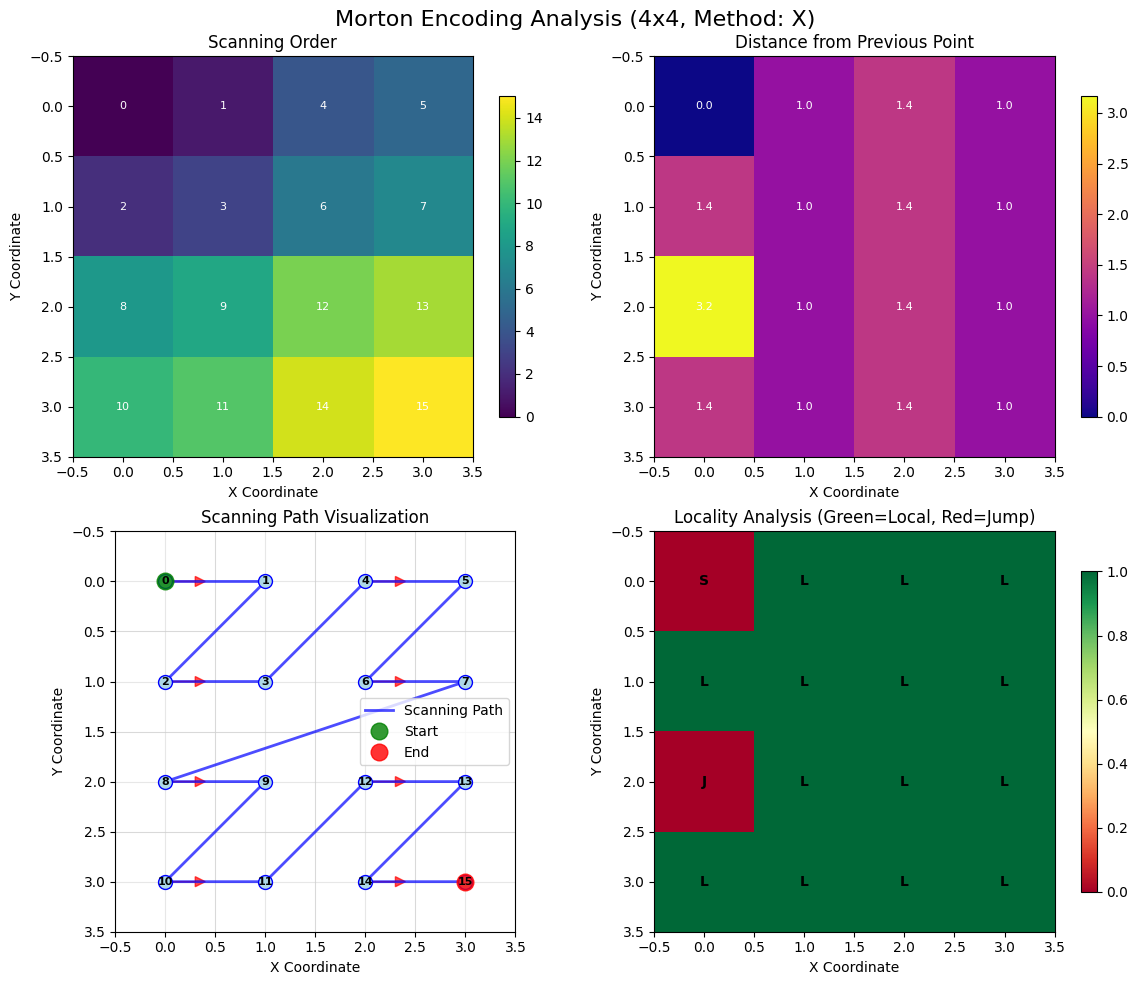


Statistical comparison:


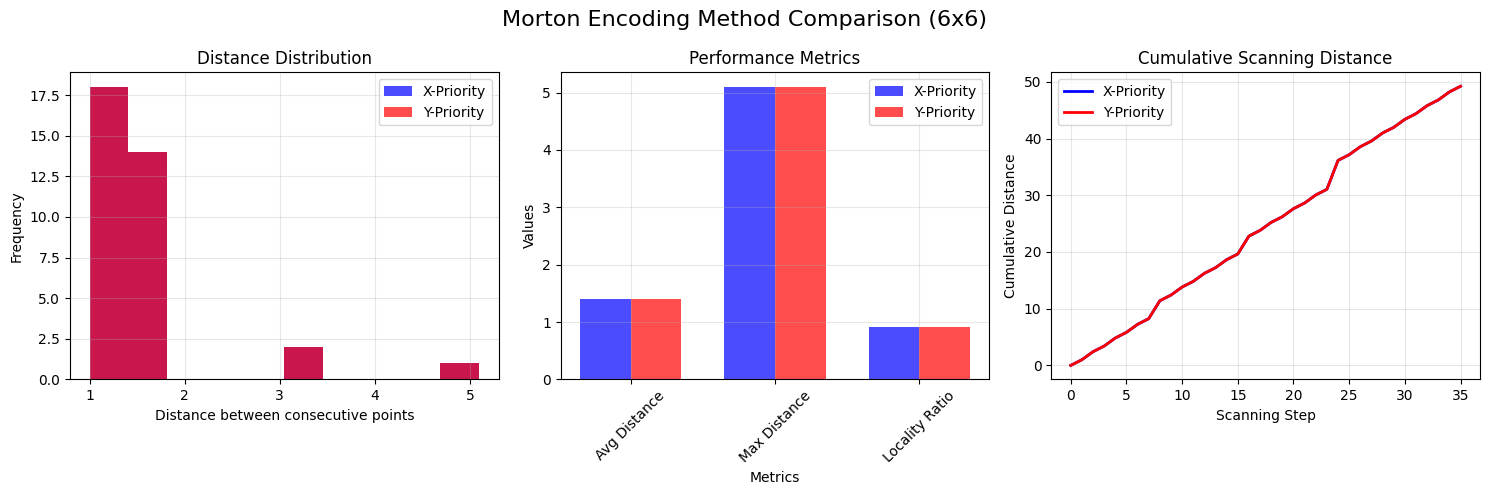


Larger grid analysis:


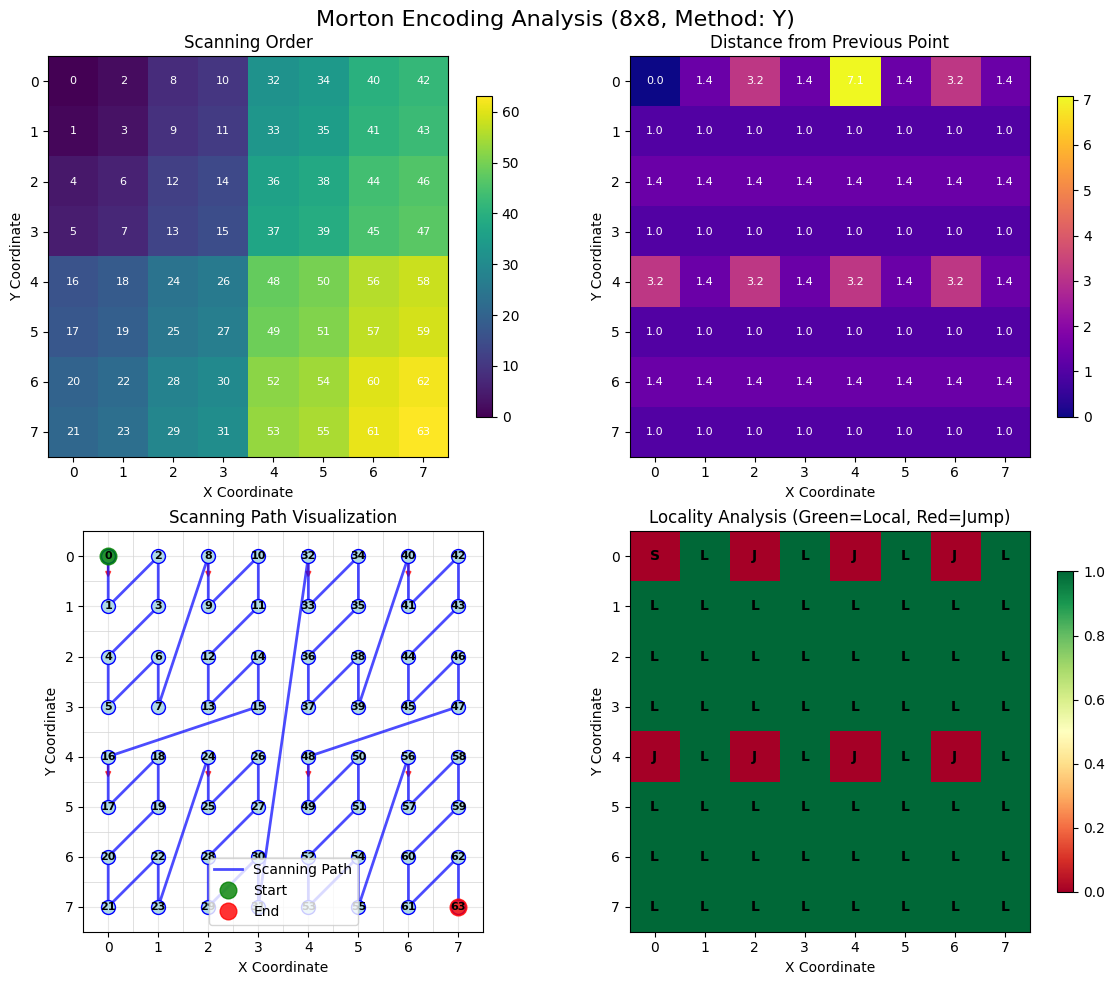

(tensor([[ 0,  2,  8,  ..., 34, 40, 42],
         [ 1,  3,  9,  ..., 35, 41, 43],
         [ 4,  6, 12,  ..., 38, 44, 46],
         ...,
         [17, 19, 25,  ..., 51, 57, 59],
         [20, 22, 28,  ..., 54, 60, 62],
         [21, 23, 29,  ..., 55, 61, 63]]),
 [(0, 0),
  (0, 1),
  (1, 0),
  (1, 1),
  (0, 2),
  (0, 3),
  (1, 2),
  (1, 3),
  (2, 0),
  (2, 1),
  (3, 0),
  (3, 1),
  (2, 2),
  (2, 3),
  (3, 2),
  (3, 3),
  (0, 4),
  (0, 5),
  (1, 4),
  (1, 5),
  (0, 6),
  (0, 7),
  (1, 6),
  (1, 7),
  (2, 4),
  (2, 5),
  (3, 4),
  (3, 5),
  (2, 6),
  (2, 7),
  (3, 6),
  (3, 7),
  (4, 0),
  (4, 1),
  (5, 0),
  (5, 1),
  (4, 2),
  (4, 3),
  (5, 2),
  (5, 3),
  (6, 0),
  (6, 1),
  (7, 0),
  (7, 1),
  (6, 2),
  (6, 3),
  (7, 2),
  (7, 3),
  (4, 4),
  (4, 5),
  (5, 4),
  (5, 5),
  (4, 6),
  (4, 7),
  (5, 6),
  (5, 7),
  (6, 4),
  (6, 5),
  (7, 4),
  (7, 5),
  (6, 6),
  (6, 7),
  (7, 6),
  (7, 7)])

In [27]:
print("Plotting improved 4x4 grid analysis:")
scan_order, coords = plot_scanning_route(4, 4, encoding_method='x')

print("\nStatistical comparison:")
plot_morton_statistics(6, 6)

print("\nLarger grid analysis:")
plot_scanning_route(8, 8, encoding_method='y')




# # ---- 设定BEV特征图尺寸 ----
# H_feature = 4
# W_feature = 4
# # ---- 完整输出 ----
# torch.set_printoptions(threshold=H_feature * W_feature + 10)
# # ---- 生成网格坐标 ----
# grid_coords = generate_grid_coordinates(H_feature, W_feature)
# print("-" * 30)
# # ---- 计算M_x ----
# morton_x_encoded = morton_encode_2d_tensor_x(grid_coords)
# print("Morton X-Encoded Output (M_x):")
# print(morton_x_encoded)
# print("-" * 30)
# # ---- 计算M_y ----
# morton_y_encoded = morton_encode_2d_tensor_y(grid_coords)
# print("Morton Y-Encoded Output (M_y):")
# print(morton_y_encoded)
# print("-" * 30)
# # ---- 计算x ----
# x = torch.arange(H_feature * W_feature, dtype=torch.float32).reshape(H_feature, W_feature)
# print("x:")
# print(x)
# print("-" * 30)
# # ---- 计算y ----
# y = torch.arange(H_feature * W_feature, dtype=torch.float32).reshape(H_feature, W_feature).T
# print("y:")
# print(y)
# print("-" * 30)

# avg_diff_x = calculate_max_morton_difference(morton_x_encoded)
# print("Average Neighbor Difference for M_x:")
# print(avg_diff_x)
# print("Shape:", avg_diff_x.shape)
# print("-" * 30)
# print(f"Calculated M_x[0,0] avg diff: {avg_diff_x[0,0].item():.4f} (Expected: 1.5000)")
# print(f"Calculated M_x[1,1] avg diff: {avg_diff_x[1,1].item():.4f} (Expected: 1.5000)")
# print("-" * 30)

# avg_diff_y = calculate_max_morton_difference(morton_y_encoded)
# print("Average Neighbor Difference for M_y:")
# print(avg_diff_y)
# print("Shape:", avg_diff_y.shape)
# print("-" * 30)
# print(f"Calculated M_y[0,0] avg diff: {avg_diff_y[0,0].item():.4f} (Expected: 1.5000)")